In [1]:
import cptac
import scipy
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import statistics
import parse_correlations_dataframe as get_corr
import copy

cptac warning: Your version of cptac (0.8.6) is out-of-date. Latest is 0.8.8. Please run 'pip install --upgrade cptac' to update it. (<ipython-input-1-147bbc873c03>, line 1)


In [18]:
def find_mutation_corr_effect(cancer_type, gene, corr_dif = True):
    gene_multi = cancer_type.multi_join({'proteomics': gene, 'transcriptomics': gene, 'somatic_mutation': gene})
    print(gene_multi)
    if gene_multi[str(gene + '_proteomics')].isnull().values.any():
        return float("NaN"), float("NaN"), float("NaN")    
    trans = list(gene_multi[str(gene +"_transcriptomics")])
    prot = list(gene_multi[str(gene + '_proteomics')])
    group = []
    for i in gene_multi[str(gene + '_Mutation_Status')]:
        if type(i) == str:
            group.append("mutation")
        else:
            group.append("wt")           
    gene_df = pd.DataFrame({'Type': group, 'Proteomics': prot, 'Transcriptomics': trans})
    is_mut = gene_df['Type'] == 'mutation'
    is_wt = gene_df['Type'] == 'wt'
    gene_df = gene_df.dropna()
    if len(gene_df[is_mut]['Proteomics']) < 2 or len(gene_df[is_mut]['Transcriptomics']) < 2 or len(gene_df[is_wt]['Proteomics']) < 2 or len(gene_df[is_wt]['Transcriptomics']) < 2:
        return float("NaN"), float("NaN"), float("NaN")
    gene_cor, gen_pval = scipy.stats.pearsonr(gene_df[is_mut]['Proteomics'], gene_df[is_mut]['Transcriptomics'])
    wt_cor, wt_pval = scipy.stats.pearsonr(gene_df[is_wt]['Proteomics'], gene_df[is_wt]['Transcriptomics'])
    gene_m, gene_b, gene_r, gene_p, gene_se = stats.linregress(gene_df[is_mut]['Proteomics'], gene_df[is_mut]['Transcriptomics'])
    wt_m, wt_b, wt_r, wt_p, wt_se = stats.linregress(gene_df[is_wt]['Proteomics'], gene_df[is_wt]['Transcriptomics'])
    gene_r2 = gene_r ** 2
    wt_r2 = wt_r ** 2
    r2_delta = gene_r2 - wt_r2
    corr_dif = gene_cor - wt_cor
    if corr_dif:
        return abs(corr_dif), r2_delta, gene_df
    else: 
        return gene_cor, wt_cor, gene_df
    

In [3]:
def find_norm_tumor_corr_effect(cancer_type, gene):
    tumor = cancer_type.multi_join({'proteomics': gene, 'transcriptomics': gene}, tissue_type= 'tumor', flatten = True)
    normal = cancer_type.multi_join({'proteomics': gene, 'transcriptomics': gene}, tissue_type= 'normal', flatten = True)
    tumor = tumor.dropna()
    normal = normal.dropna()
    if len(normal) < 2 or len(tumor) < 2:
        return float("NaN"), float("NaN"), float("NaN")
    tumor.columns = ['proteomics', 'transcriptomics']
    normal.columns = ['proteomics', 'transcriptomics']
    groups = ['tumor'] * len(tumor)
    groups.extend(['normal']*len(normal))
    prot_list = list(tumor['proteomics'])
    prot_list.extend(list(normal['proteomics']))
    trans_list = list(tumor['transcriptomics'])
    trans_list.extend(list(normal['transcriptomics']))
    gene_df = pd.DataFrame({'Type': groups, 'Proteomics': prot_list, 'Transcriptomics': trans_list})
    is_tum = gene_df['Type'] == 'tumor'
    is_norm = gene_df['Type'] == 'normal'
    tum_cor, tum_pval = scipy.stats.pearsonr(gene_df[is_tum]['Proteomics'], gene_df[is_tum]['Transcriptomics'])
    norm_cor, norm_pval = scipy.stats.pearsonr(gene_df[is_norm]['Proteomics'], gene_df[is_norm]['Transcriptomics'])
    return tum_cor, norm_cor, gene_df
        
        
    

In [4]:
def get_cancer_string(cancer):
    if cancer == brca:
        return "brca"
    if cancer == ccrcc:
        return "ccrcc"
    if cancer == colon:
        return 'colon'
    if cancer == en:
        return 'en'
    if cancer == gbm:
        return 'gbm'
    if cancer == luad:
        return 'luad'
    if cancer == ovarian:
        return 'ovarian'
    if cancer == hnscc:
        return 'hnscc'
    if cancer == lscc:
        return 'lscc'

In [5]:
brca = cptac.Brca()
ccrcc = cptac.Ccrcc()
colon = cptac.Colon()
en = cptac.Endometrial()
gbm = cptac.Gbm()
luad = cptac.Luad()
ovarian = cptac.Ovarian()
hnscc  = cptac.Hnscc()
lscc = cptac.Lscc()

cptac warning: The GBM dataset is under publication embargo until March 01, 2021. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (<ipython-input-5-0467c23f8dc0>, line 5)


cptac warning: The HNSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (<ipython-input-5-0467c23f8dc0>, line 8)


cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (<ipython-input-5-0467c23f8dc0>, line 9)


In [6]:
gene = 'KRAS'
tumor = ccrcc.multi_join({'proteomics': gene, 'transcriptomics': gene}, tissue_type= 'tumor', flatten = False)
tumor = tumor.dropna()
print(tumor)

tumor = ccrcc.join_omics_to_omics('proteomics', 'transcriptomics', genes1 = gene, genes2 = gene)
print(tumor)

Name        KRAS_proteomics             KRAS_transcriptomics
Database_ID     NP_004976.2 NP_203524.1                     
Patient_ID                                                  
C3L-00079         -0.222096   -0.088909             6.352764
C3L-00910          0.490832    0.450157            10.446762
C3L-01281         -0.306274   -0.097409             6.565567
C3N-00495          0.047788    0.654244             5.817948
C3N-00831          0.093145    0.619984             4.848198
C3N-01220          0.102117    0.402413             6.450097
C3N-01522         -0.187688   -0.180526             6.034788
C3N-01646         -0.178977   -0.079340             5.296055
Name        KRAS_proteomics             KRAS_transcriptomics
Database_ID     NP_004976.2 NP_203524.1                     
Patient_ID                                                  
C3L-00004         -0.393854         NaN             8.363200
C3L-00010         -0.085605         NaN             7.786690
C3L-00011         -0.206

cptac warning: transcriptomics data was not found for the following samples, so transcriptomics data columns were filled with NaN for these samples: C3L-00183.N, C3L-00791.N, C3N-00246.N, C3N-00312.N, C3N-00317.N, C3N-00320.N, C3N-00437.N, C3N-00492.N, C3N-00953.N (<ipython-input-6-7d73838dd191>, line 6)


In [7]:
cancer_genes = ['BRAF','TP53','BRCA2','KRAS','PIK3CA','PTEN']

In [8]:
cancer_list = [brca,ccrcc,colon,luad,ovarian,hnscc,lscc]

In [9]:
tum_corr = []
norm_corr = []
gene_dfs = []
genes = []
cancer_type = []
for cancer in cancer_list:
    for gene in cancer_genes:
        if gene == "KRAS" and cancer == ccrcc:
            continue
        tum_cor, norm_cor, gene_df = find_norm_tumor_corr_effect(cancer, gene)
        if not np.isnan(tum_cor):
            tum_corr.append(tum_cor)
            norm_corr.append(norm_cor)
            gene_dfs.append(gene_df)
            cancer_type.append(get_cancer_string(cancer))
            genes.append(gene)
norm_tumor_effects = pd.DataFrame({'cancer': cancer_type, 'gene': genes, 'tumor_correlation': tum_corr, 'normal_correlation': norm_corr, 'gene_df': gene_dfs})
norm_tumor_effects.head()
        
        
        
        
        

cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (C:\Users\nanel\anaconda3\lib\site-packages\cptac\dataset.py, line 697)
cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (C:\Users\nanel\anaconda3\lib\site-packages\cptac\dataset.py, line 697)
cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (C:\Users\nanel\anaconda3\lib\site-packages\cptac\dataset.py, line 697)
cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (C:\Users\nanel\anaconda3\lib\site-packages\cptac\dataset.py, line 697)
cptac warning: The following columns were not found in the proteomics dataframe, so they were inserted into joined table, but filled with NaN: BRCA2 (<ipython-input-3-4eb76cdc6c64>, line 2)
cptac warning: You tried t

,cancer,gene,tumor_correlation,normal_correlation,gene_df
0,ccrcc,BRAF,0.546805,0.081654,Type Proteomics Transcriptomics 0 ...
1,ccrcc,TP53,0.146573,-0.278706,Type Proteomics Transcriptomics 0 t...
2,ccrcc,BRCA2,-0.341958,-0.662538,Type Proteomics Transcriptomics 0 t...
3,ccrcc,PIK3CA,0.521751,0.199898,Type Proteomics Transcriptomics 0 ...
4,ccrcc,PTEN,0.497284,0.649130,Type Proteomics Transcriptomics 0 ...


In [10]:
norm_tumor_effects = norm_tumor_effects.assign(cor_dif = abs(norm_tumor_effects['tumor_correlation'] - norm_tumor_effects['normal_correlation']))

In [11]:
norm_tumor_effects.head()

,cancer,gene,tumor_correlation,normal_correlation,gene_df,cor_dif
0,ccrcc,BRAF,0.546805,0.081654,Type Proteomics Transcriptomics 0 ...,0.465151
1,ccrcc,TP53,0.146573,-0.278706,Type Proteomics Transcriptomics 0 t...,0.425279
2,ccrcc,BRCA2,-0.341958,-0.662538,Type Proteomics Transcriptomics 0 t...,0.320580
3,ccrcc,PIK3CA,0.521751,0.199898,Type Proteomics Transcriptomics 0 ...,0.321853
4,ccrcc,PTEN,0.497284,0.649130,Type Proteomics Transcriptomics 0 ...,0.151846


In [12]:
norm_tumor_effects = norm_tumor_effects.sort_values(by = 'cor_dif', ascending=False, ignore_index=True)
norm_tumor_effects.head()

,cancer,gene,tumor_correlation,normal_correlation,gene_df,cor_dif
0,lscc,TP53,0.723227,-0.344411,Type Proteomics Transcriptomics 0 ...,1.067638
1,hnscc,PIK3CA,0.814412,0.028087,Type Proteomics Transcriptomics 0 ...,0.786325
2,hnscc,PTEN,0.636979,-0.073318,Type Proteomics Transcriptomics 0 ...,0.710297
3,luad,TP53,0.496929,-0.193213,Type Proteomics Transcriptomics 0 ...,0.690142
4,lscc,PTEN,0.695318,0.054532,Type Proteomics Transcriptomics 0 ...,0.640787


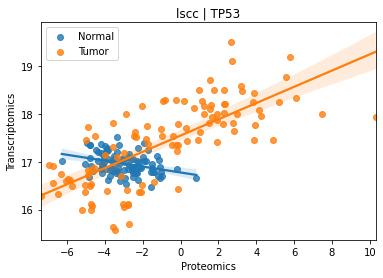

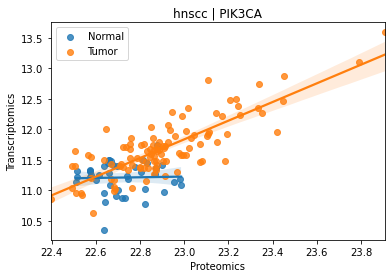

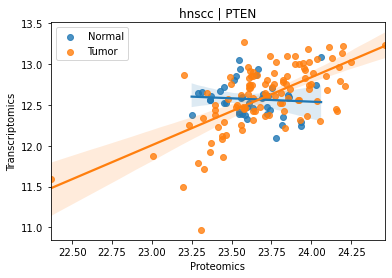

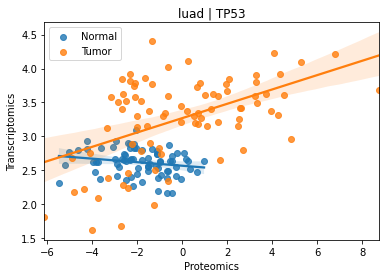

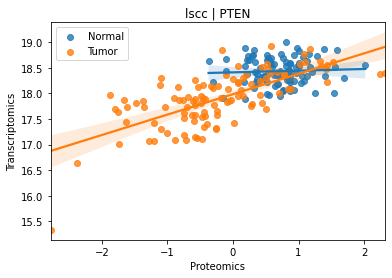

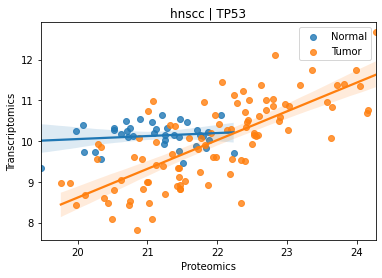

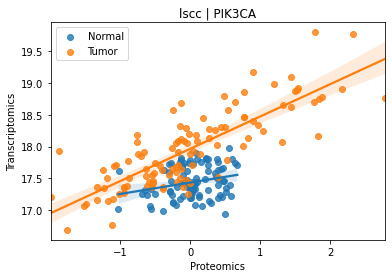

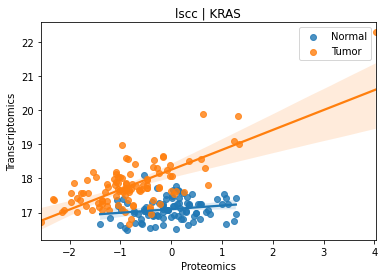

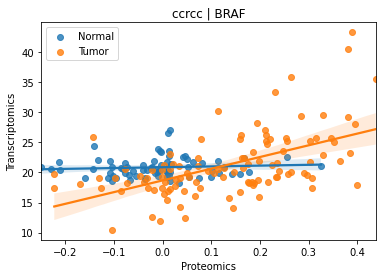

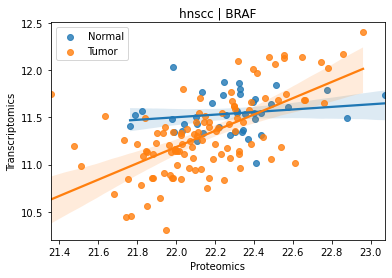

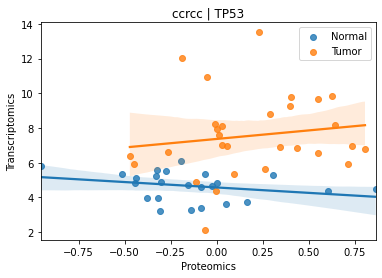

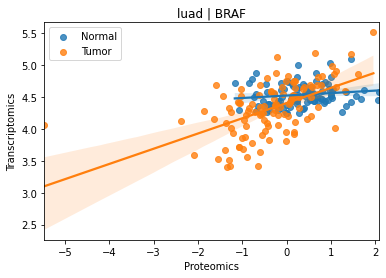

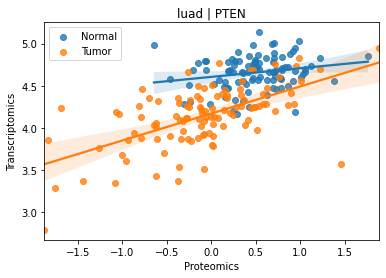

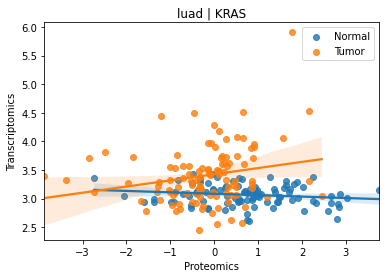

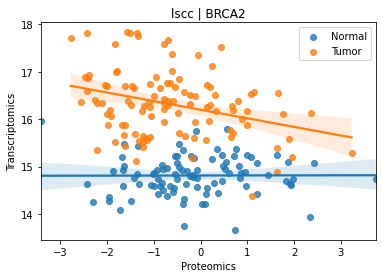

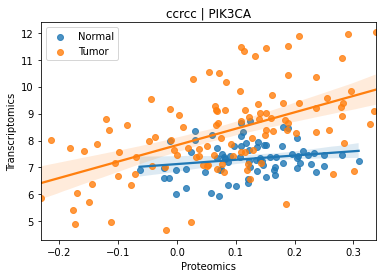

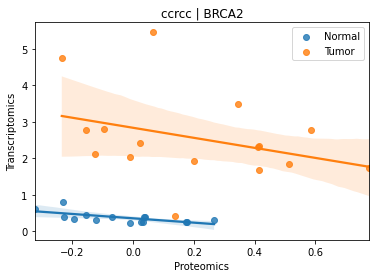

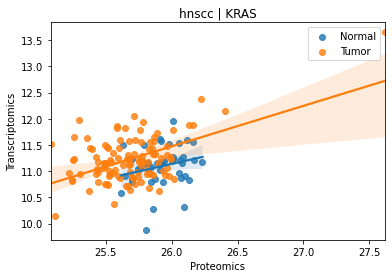

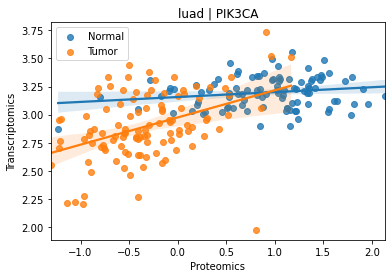

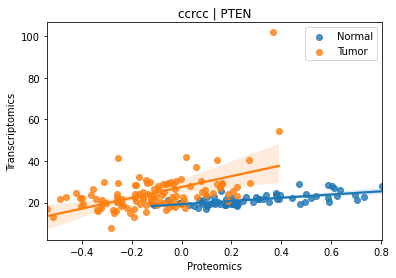

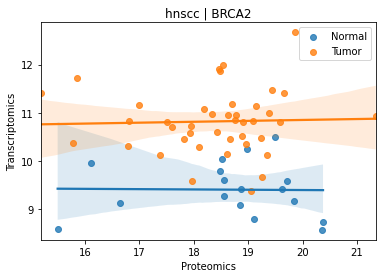

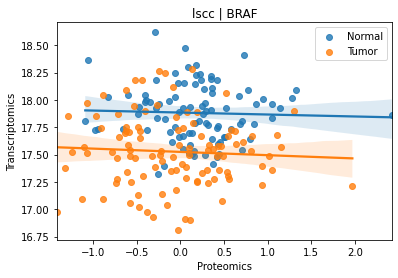

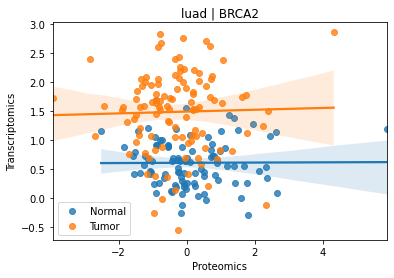

In [13]:
for index, df in enumerate(norm_tumor_effects['gene_df']):
    is_norm = df['Type']=='normal'
    is_tum = df['Type'] == 'tumor'
    ax = sns.regplot(x = 'Proteomics', y = 'Transcriptomics', data = df[is_norm], label = "Normal")
    ax = sns.regplot(x = 'Proteomics', y = 'Transcriptomics', data = df[is_tum], label = 'Tumor')
    ax.legend(loc = 'best')
    plt.title(str(norm_tumor_effects['cancer'][index] + ' | ' + norm_tumor_effects['gene'][index]))
    plt.show()

In [14]:
#focus on kras and pten

In [15]:
dfs = []
for cancer in cancer_list:
    for gene in cancer_genes:
        if gene == "KRAS" and cancer == ccrcc:
            continue
        tum_cor, norm_cor, gene_df = find_norm_tumor_corr_effect(cancer, gene)
        if not np.isnan(tum_cor):
            gene_df['cancer'] = [get_cancer_string(cancer)]*len(gene_df)
            gene_df['gene'] = [gene]*len(gene_df)
            dfs.append(gene_df)
print(dfs)
        
        
        

cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (C:\Users\nanel\anaconda3\lib\site-packages\cptac\dataset.py, line 697)
cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (C:\Users\nanel\anaconda3\lib\site-packages\cptac\dataset.py, line 697)
cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (C:\Users\nanel\anaconda3\lib\site-packages\cptac\dataset.py, line 697)
cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (C:\Users\nanel\anaconda3\lib\site-packages\cptac\dataset.py, line 697)
cptac warning: The following columns were not found in the proteomics dataframe, so they were inserted into joined table, but filled with NaN: BRCA2 (<ipython-input-3-4eb76cdc6c64>, line 2)
cptac warning: You tried t

[       Type  Proteomics  Transcriptomics cancer  gene
0     tumor    0.235538        21.616591  ccrcc  BRAF
1     tumor    0.232718        19.209432  ccrcc  BRAF
2     tumor    0.034752        14.278585  ccrcc  BRAF
3     tumor    0.328557        22.972120  ccrcc  BRAF
4     tumor    0.136153        15.809168  ccrcc  BRAF
..      ...         ...              ...    ...   ...
180  normal   -0.006068        20.481532  ccrcc  BRAF
181  normal    0.009571        19.272746  ccrcc  BRAF
182  normal   -0.069232        19.506177  ccrcc  BRAF
183  normal   -0.015187        19.897661  ccrcc  BRAF
184  normal   -0.104049        20.944983  ccrcc  BRAF

[185 rows x 5 columns],       Type  Proteomics  Transcriptomics cancer  gene
0    tumor    0.402191         9.780815  ccrcc  TP53
1    tumor    0.092737         5.350098  ccrcc  TP53
2    tumor    0.288820         8.795810  ccrcc  TP53
3    tumor    0.346025         6.911960  ccrcc  TP53
4    tumor   -0.265361         6.610207  ccrcc  TP53
5    tum

In [16]:
norm_tumor_effects_facet_graph = pd.concat(dfs)
norm_tumor_effects_facet_graph.head()

,Type,Proteomics,Transcriptomics,cancer,gene
0,tumor,0.235538,21.616591,ccrcc,BRAF
1,tumor,0.232718,19.209432,ccrcc,BRAF
2,tumor,0.034752,14.278585,ccrcc,BRAF
3,tumor,0.328557,22.972120,ccrcc,BRAF
4,tumor,0.136153,15.809168,ccrcc,BRAF


In [19]:
corr_diffs = []
r2_deltas = []
filtered_genes = []
gene_dfs = []
for gene in cancer_genes:
    print(gene)
    cor, r2, gene_df = find_mutation_corr_effect(en, gene)
    if not np.isnan(cor):
        corr_diffs.append(cor)
        r2_deltas.append(r2)
        filtered_genes.append(gene)
        gene_dfs.append(gene_df)
en_mutation_effects = pd.DataFrame({'gene': filtered_genes, 'correlation_difference': corr_diffs, "r2_delta" : r2_deltas, "gene_dataframes": gene_dfs})


BRAF
Name         BRAF_proteomics  BRAF_transcriptomics BRAF_Mutation  \
Patient_ID                                                         
C3L-00006            -0.1160                 11.86           NaN   
C3L-00006.N           0.1070                 12.24           NaN   
C3L-00008            -0.1220                 11.17           NaN   
C3L-00032            -0.1070                 11.26           NaN   
C3L-00090             0.1910                 12.07           NaN   
...                      ...                   ...           ...   
NX5.N                -0.0575                   NaN           NaN   
NX6.N                 0.0902                   NaN           NaN   
NX7.N                -0.1010                   NaN           NaN   
NX8.N                 0.0988                   NaN           NaN   
NX9.N                 0.0121                   NaN           NaN   

Name        BRAF_Location BRAF_Mutation_Status  
Patient_ID                                      
C3L-00006   

<ipython-input-18-566bbd889feb>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if len(gene_df[is_mut]['Proteomics']) < 2 or len(gene_df[is_mut]['Transcriptomics']) < 2 or len(gene_df[is_wt]['Proteomics']) < 2 or len(gene_df[is_wt]['Transcriptomics']) < 2:
cptac warning: The following columns were not found in the proteomics dataframe, so they were inserted into joined table, but filled with NaN: BRCA2 (<ipython-input-18-566bbd889feb>, line 2)


Name         BRCA2_proteomics  BRCA2_transcriptomics BRCA2_Mutation  \
Patient_ID                                                            
C3L-00006                 NaN                  11.87            NaN   
C3L-00006.N               NaN                   8.75            NaN   
C3L-00008                 NaN                  11.07            NaN   
C3L-00032                 NaN                  10.27            NaN   
C3L-00090                 NaN                  10.15            NaN   
...                       ...                    ...            ...   
NX5.N                     NaN                    NaN            NaN   
NX6.N                     NaN                    NaN            NaN   
NX7.N                     NaN                    NaN            NaN   
NX8.N                     NaN                    NaN            NaN   
NX9.N                     NaN                    NaN            NaN   

Name        BRCA2_Location BRCA2_Mutation_Status  
Patient_ID               

<ipython-input-18-566bbd889feb>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if len(gene_df[is_mut]['Proteomics']) < 2 or len(gene_df[is_mut]['Transcriptomics']) < 2 or len(gene_df[is_wt]['Proteomics']) < 2 or len(gene_df[is_wt]['Transcriptomics']) < 2:
<ipython-input-18-566bbd889feb>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gene_cor, gen_pval = scipy.stats.pearsonr(gene_df[is_mut]['Proteomics'], gene_df[is_mut]['Transcriptomics'])
<ipython-input-18-566bbd889feb>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wt_cor, wt_pval = scipy.stats.pearsonr(gene_df[is_wt]['Proteomics'], gene_df[is_wt]['Transcriptomics'])
<ipython-input-18-566bbd889feb>:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gene_m, gene_b, gene_r, gene_p, gene_se = stats.linregress(gene_df[is_mut]['Proteomics'], gene_df[is_mut]['Transcriptomics'])
<ipython-input-18-566bbd889f

Name         PIK3CA_proteomics  PIK3CA_transcriptomics      PIK3CA_Mutation  \
Patient_ID                                                                    
C3L-00006               -0.450                   11.12  [Missense_Mutation]   
C3L-00006.N              0.503                   12.18                  NaN   
C3L-00008               -0.215                   10.96                  NaN   
C3L-00032               -0.178                   11.08  [Missense_Mutation]   
C3L-00090               -0.392                   11.02                  NaN   
...                        ...                     ...                  ...   
NX5.N                    0.276                     NaN                  NaN   
NX6.N                    0.350                     NaN                  NaN   
NX7.N                    0.256                     NaN                  NaN   
NX8.N                    0.208                     NaN                  NaN   
NX9.N                    0.519                     N

<ipython-input-18-566bbd889feb>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if len(gene_df[is_mut]['Proteomics']) < 2 or len(gene_df[is_mut]['Transcriptomics']) < 2 or len(gene_df[is_wt]['Proteomics']) < 2 or len(gene_df[is_wt]['Transcriptomics']) < 2:
<ipython-input-18-566bbd889feb>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gene_cor, gen_pval = scipy.stats.pearsonr(gene_df[is_mut]['Proteomics'], gene_df[is_mut]['Transcriptomics'])
<ipython-input-18-566bbd889feb>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wt_cor, wt_pval = scipy.stats.pearsonr(gene_df[is_wt]['Proteomics'], gene_df[is_wt]['Transcriptomics'])
<ipython-input-18-566bbd889feb>:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gene_m, gene_b, gene_r, gene_p, gene_se = stats.linregress(gene_df[is_mut]['Proteomics'], gene_df[is_mut]['Transcriptomics'])
<ipython-input-18-566bbd889f